## Apply a distortion correction to raw images

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import cv2

In [44]:
# Road an image
img = cv2.imread('../test_images/test1.jpg')

More information on camera calibration can be found [here](camera_calibration.ipynb).

In [45]:
# Loading camera calibration
cameraCalibration = pickle.load( open('../camera_cal/wide_dist_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [46]:
#undistort an image
undist = cv2.undistort(img, mtx, dist, None, mtx)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [47]:
# Applying the Sobel operator to an image. 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

In [48]:
# Apply a threshold to the overall magnitude of the gradient, in both x and y.
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1    
    return mag_binary

In [49]:
# Compute the direction of the gradient and apply a threshold. 
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_arc = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(sobel_arc)
    dir_binary[(sobel_arc >= thresh[0]) & (sobel_arc <= thresh[1])] = 1
    return dir_binary

In [50]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.3))

In [51]:
# Select for pixels where both the xx and yy gradients meet the threshold criteria, 
# or the gradient magnitude and direction are both within their threshold values.
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | (mag_binary == 1) & (dir_binary == 1)] = 1

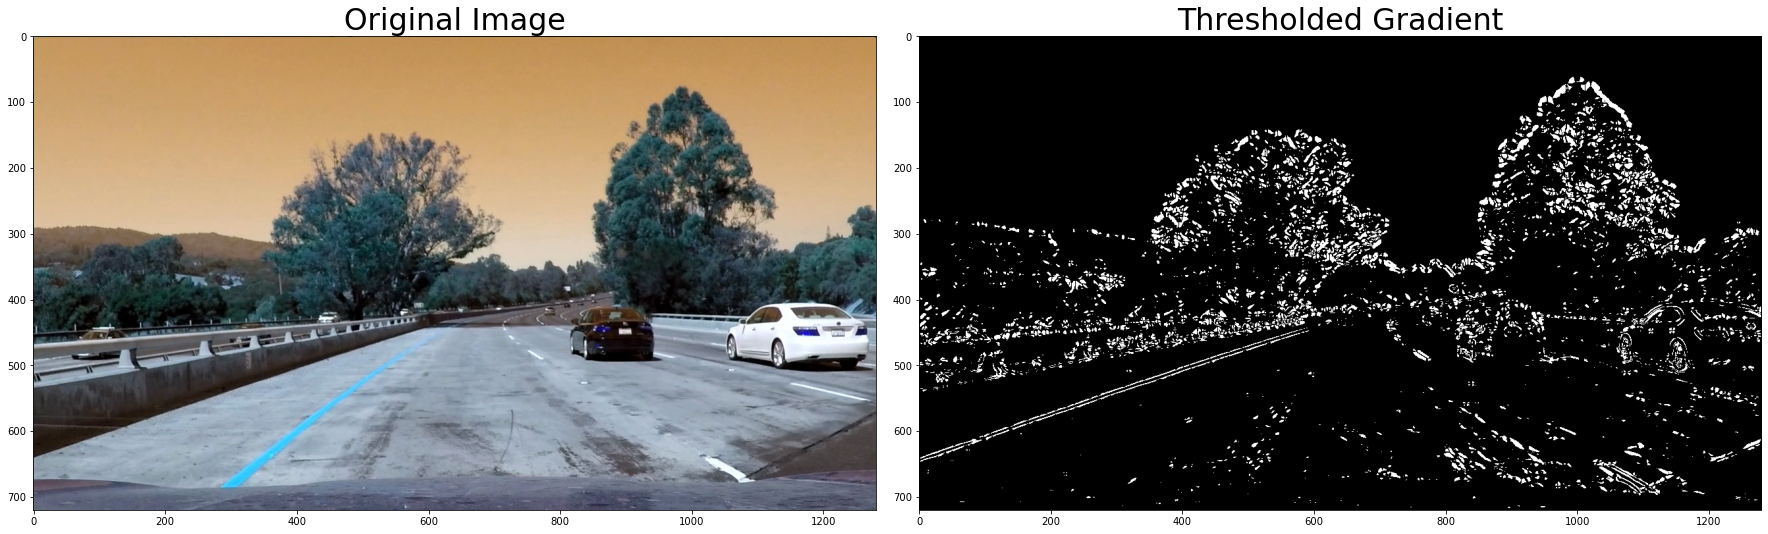

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

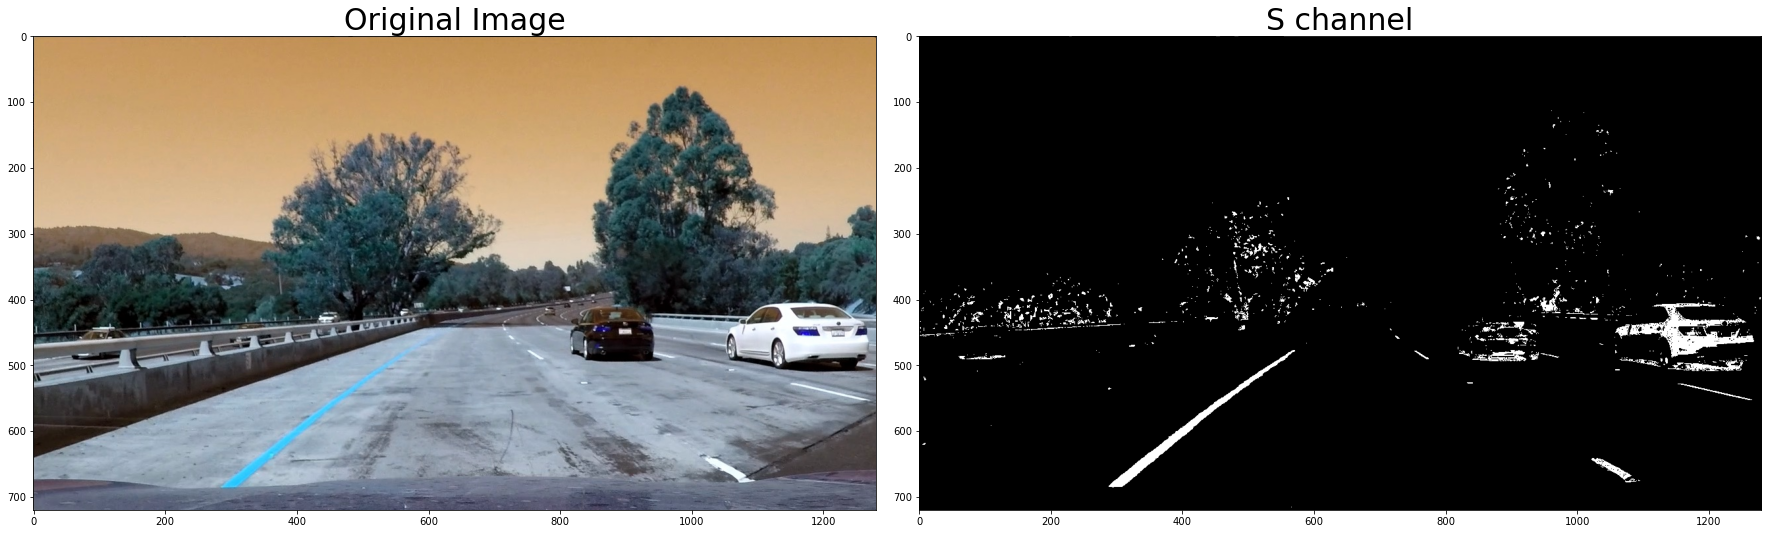

In [53]:
# Threshold color channel
def color_t(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    return s_binary

thresh = (170, 255)
s_binary = color_t(img, thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S channel', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [64]:
# Combinations of color and gradient
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    
    return s_binary

In [72]:
# Make a list of calibration images
images = glob.glob('../test_images/test*.jpg')

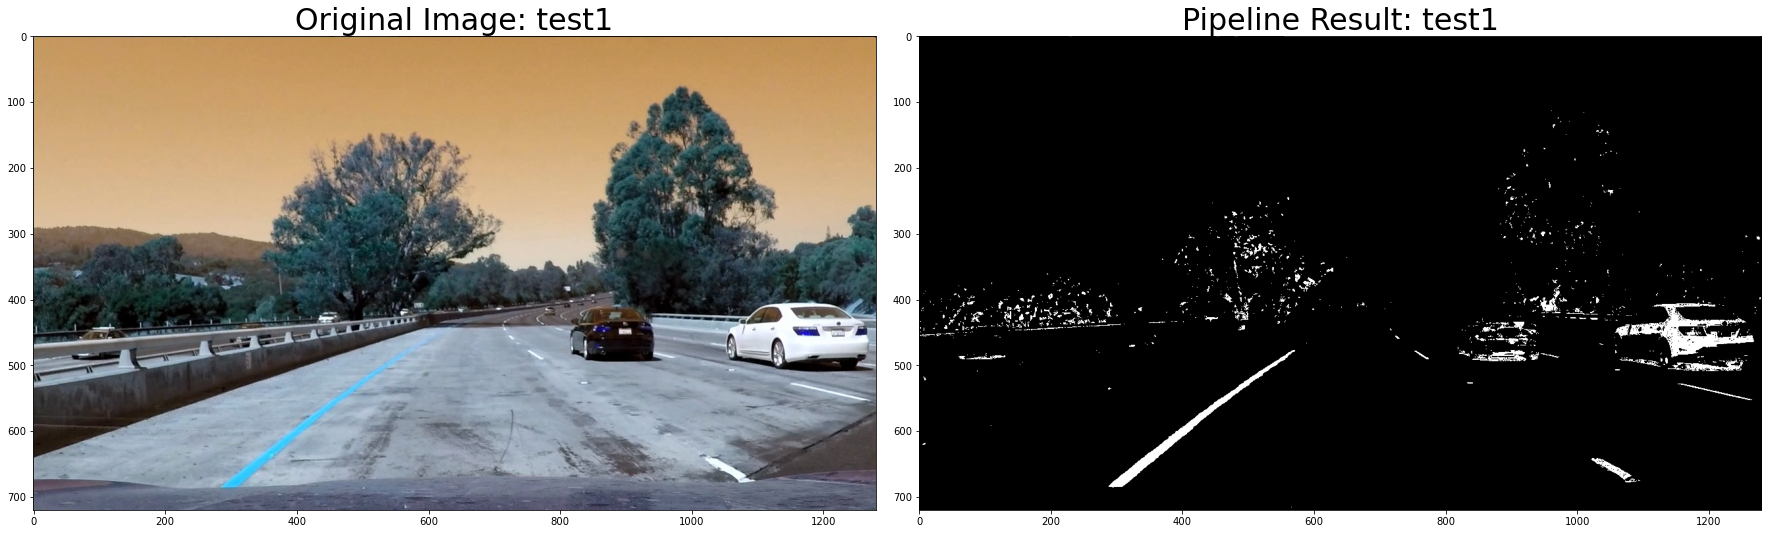

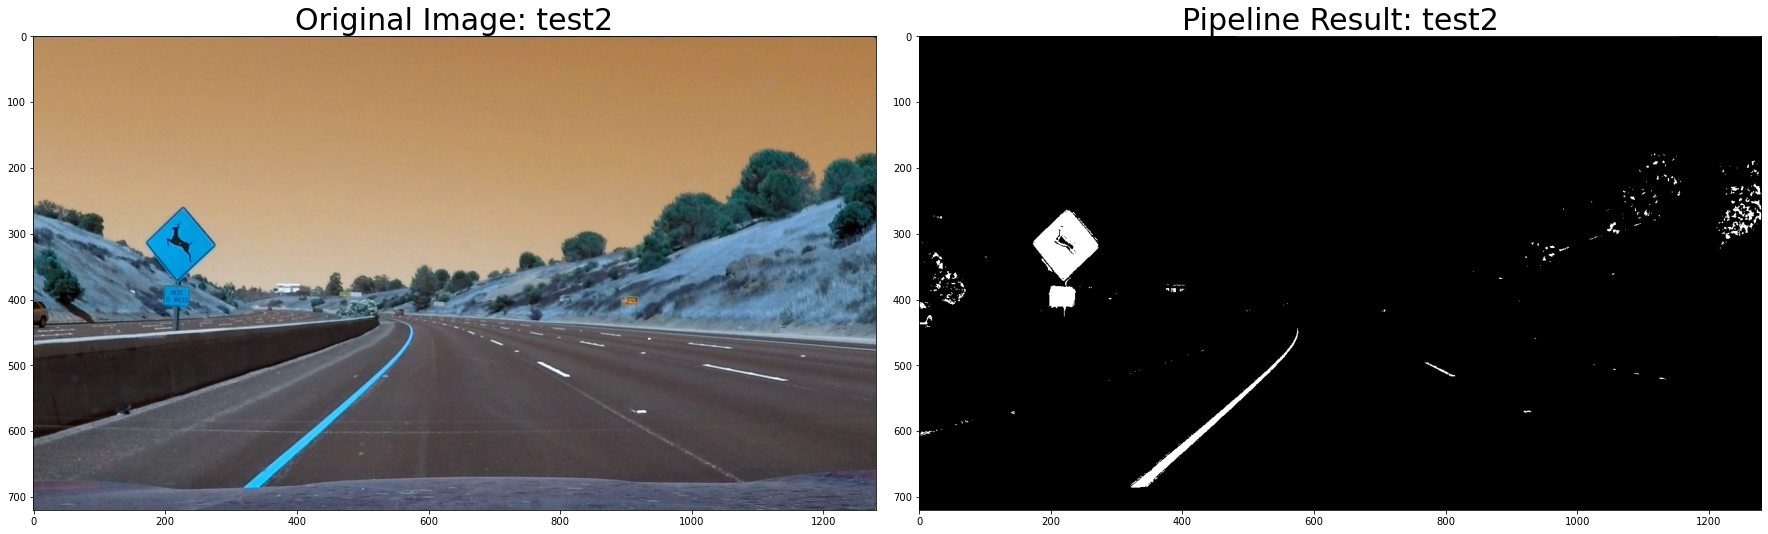

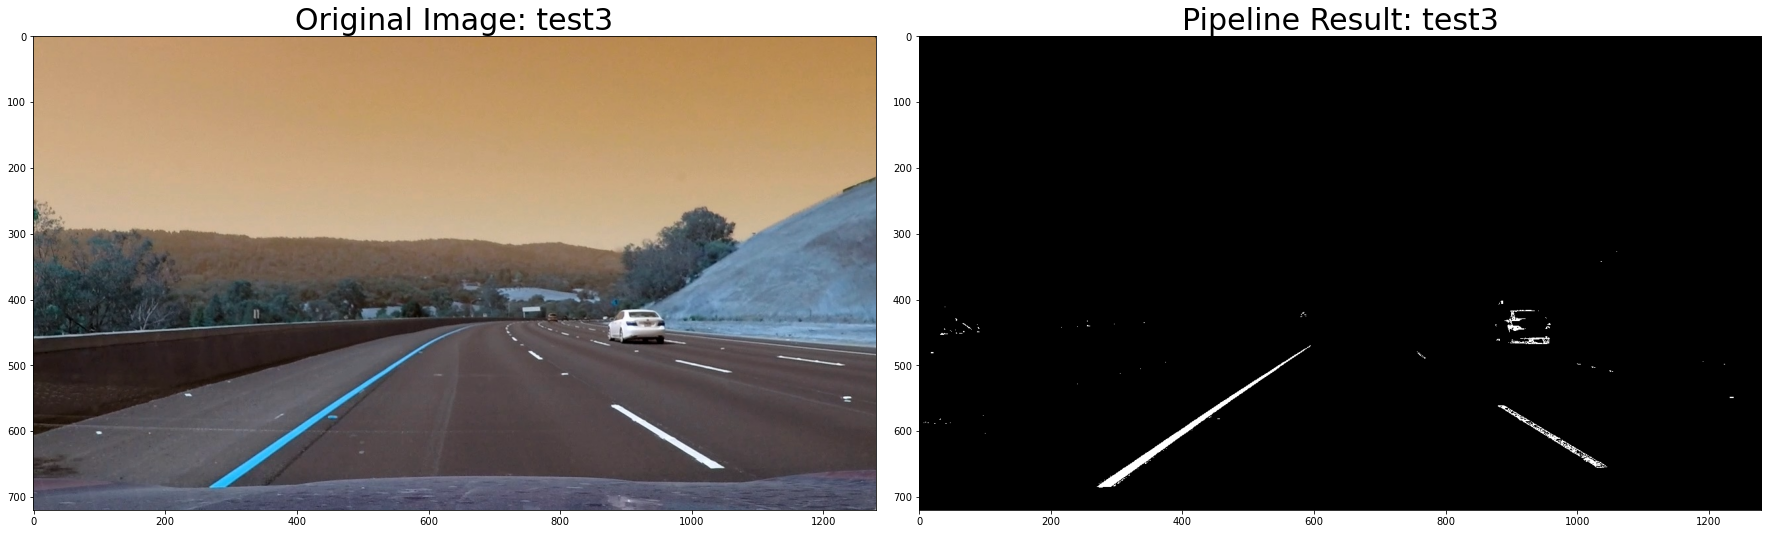

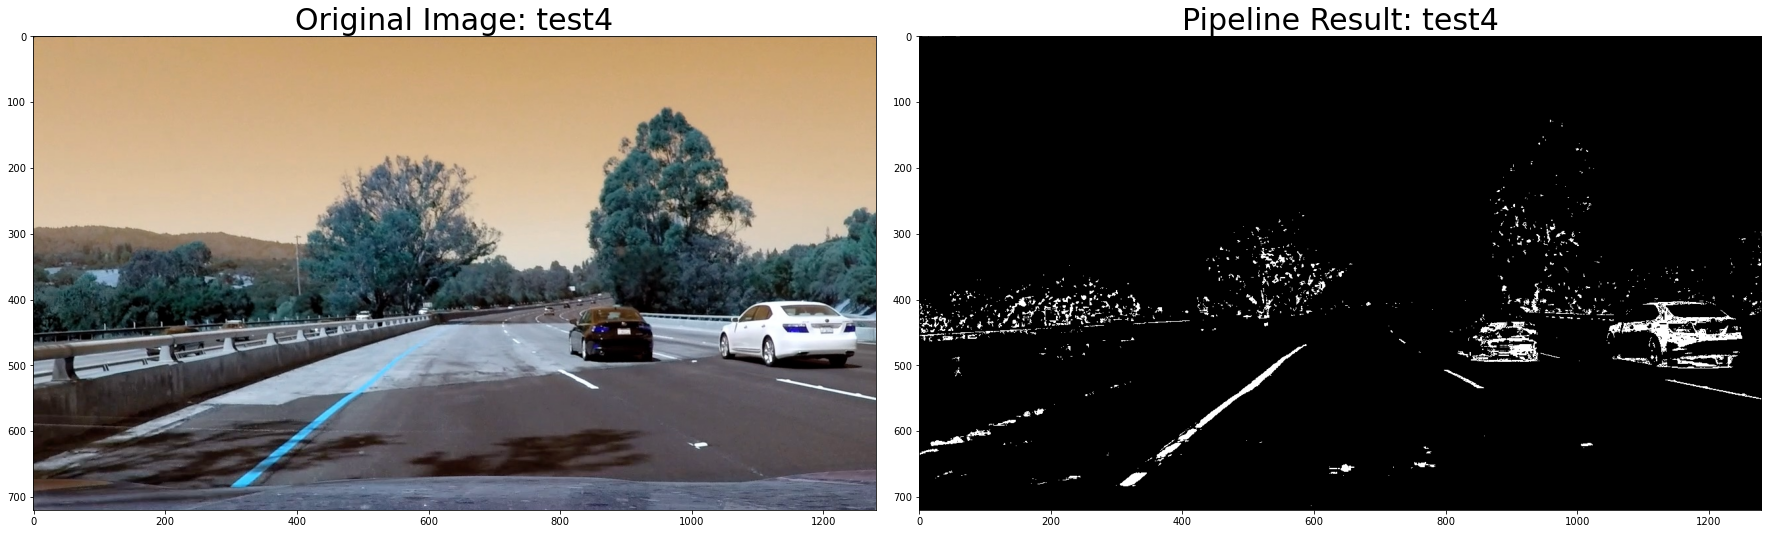

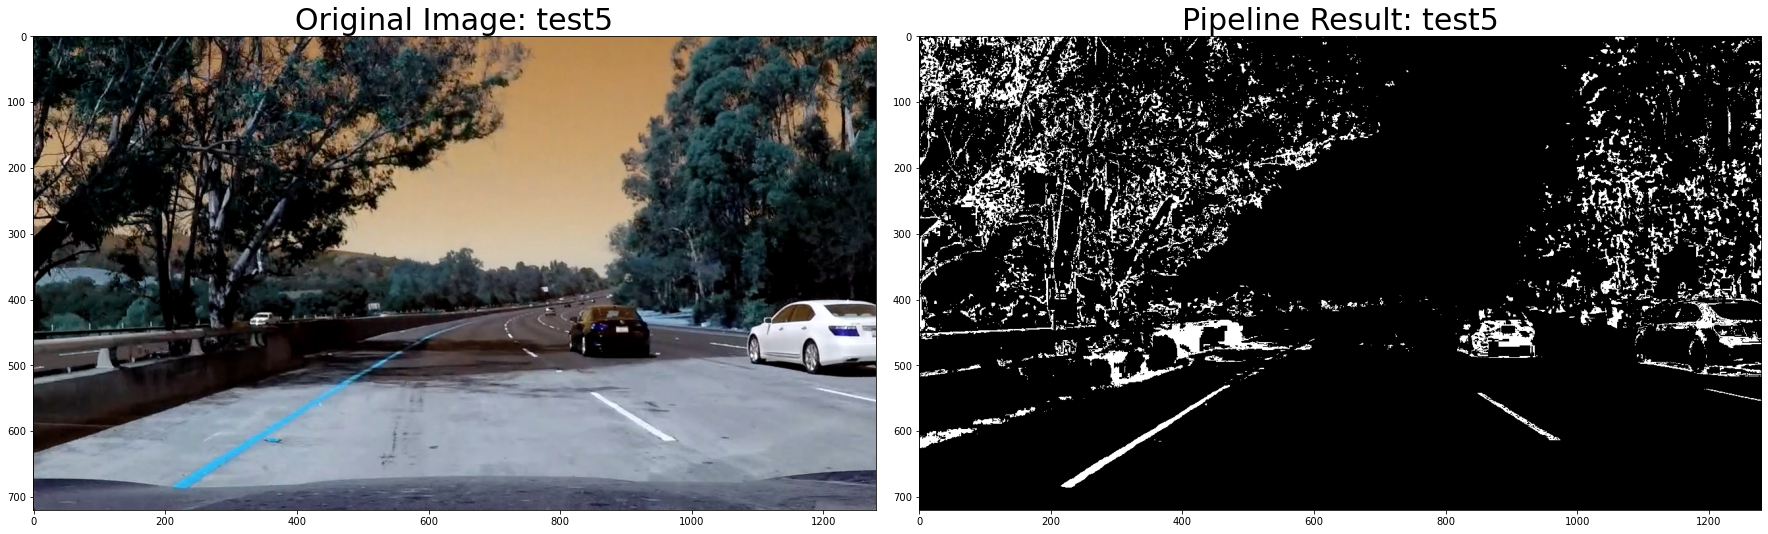

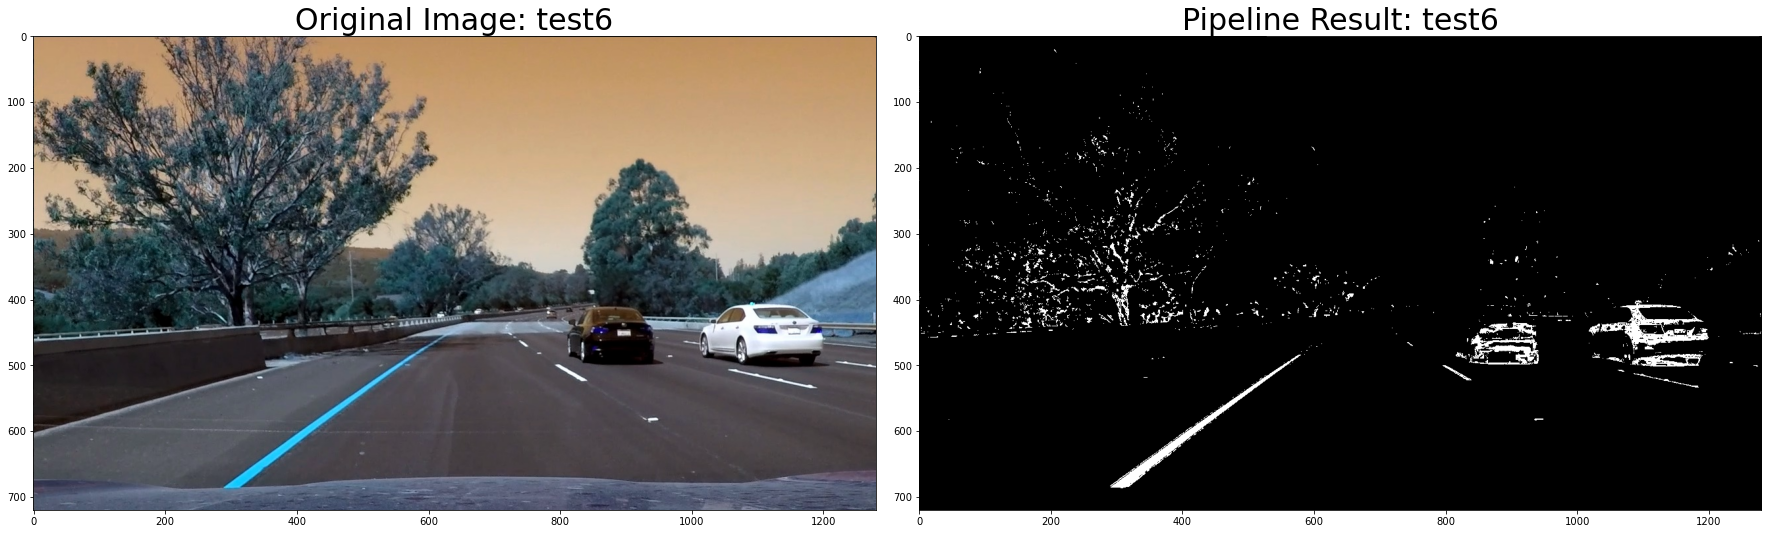

In [90]:
s_thresh=(170, 255)
sx_thresh=(20, 100)


for fname, i in zip(images, range(len(images))):
    img = cv2.imread(fname)
    result = pipeline(img, s_thresh, sx_thresh)
    out_filename = '../output_images/test' + str(i+1) + '.jpg'

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    f.tight_layout()
    cv2.imwrite(out_filename, result)

    ax1.imshow(img)
    ax1.set_title('Original Image: test{}'.format(i+1), fontsize=30)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result: test{}'.format(i+1), fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
